# 1. <big>프로젝트 개요</big>

## 1.1 프로젝트 명 및 기간

### - 프로젝트 명 : <span style=color:green>네이버</span> 영화 추천 알고리즘
### - 프로젝트 기간 : `2018.01.17 ~ 2018.3 (1.5 개월)`

## 1.2 프로젝트 `목표`

### - User 에게 가장 알맞은 `추천 영화` 목록 제공

## 1.3 프로젝트 `진행 방향`

### - Sparse matrix 알고리즘을 풀기위해 matrix factorization / Deep learning 적용

# 2. <big>데이터</big>

In [42]:
import tensorflow as tf
import requests
import pickle
import time
from bs4 import BeautifulSoup
from pandas import pivot_table
from scipy import spatial
from sklearn.model_selection import train_test_split
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.constraints import non_neg
from sklearn.metrics import mean_absolute_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input, Dense, Embedding, Reshape, Dot, Concatenate
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
tf.logging.set_verbosity(tf.logging.ERROR)

## 2-1. 데이터 `크롤링`
    - 네이버 영화 평점 사이트(https://movie.naver.com/movie/point/af/list.nhn)에서 데이터 크롤링(BeautifulSoup 이용)
    - aws 서버에서 30분 간격으로 데이터 추가 및 업데이트 
    - csv파일로 저장

## 2.2 데이터 `확인 / 분석`

### 데이터 불러오기
- rows : `27408`
- columns : `3(movie, name, point)`

In [1]:
df = pd.read_csv('movie_point_crawling.csv')
df = df[['movie','name','point']]
df.tail()

,movie,name,point
27171,보헤미안 랩소디,fhfh****,10
27172,러브 유어셀프 인 서울,podo****,10
27173,극한직업,fhfh****,10
27174,뺑반,lsj0****,1
27175,극한직업,1729****,10


In [2]:
add_df = pd.read_csv('movie.csv')
add_df = add_df[['movie', 'name','point']]
add_df.tail()

,movie,name,point
19635,타임 패러독스,ssyj****,6
19636,극한직업,bara****,8
19637,드래곤 길들이기 3,wing****,10
19638,극한직업,dlal****,10
19639,뺑반,dhds****,8


In [3]:
frames = [df, add_df]
df = pd.concat(frames, ignore_index=True)
df = df.drop_duplicates(subset=['movie', 'name'], keep='first').reset_index()
df.tail()

,index,movie,name,point
27403,46688,갈매기,rain****,9
27404,46689,뺑반,uej8****,5
27405,46690,너의 결혼식,luah****,10
27406,46692,극장판 헬로카봇:옴파로스 섬의 비밀,gkdu****,8
27407,46693,미래의 미라이,jute****,6


In [5]:
df = df[['movie','name','point']]
df.tail()

,movie,name,point
27403,갈매기,rain****,9
27404,뺑반,uej8****,5
27405,너의 결혼식,luah****,10
27406,극장판 헬로카봇:옴파로스 섬의 비밀,gkdu****,8
27407,미래의 미라이,jute****,6


In [9]:
len(df)

27408

In [6]:
df.to_csv('movie_point_crawling.csv')

### 포인트 점수
- `1점 ~ 10점`

In [10]:
sorted(df['point'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### User와 Movie 고유 번호 추가

In [11]:
df["user_id"] = df.name.astype('category').cat.codes.values
df["movie_id"] = df.movie.astype('category').cat.codes.values
df = df[['movie','name','point','user_id','movie_id']]
df = df.reset_index()
print(len(df))
df.tail()

27408


,index,movie,name,point,user_id,movie_id
27403,27403,갈매기,rain****,9,11881,91
27404,27404,뺑반,uej8****,5,14684,1019
27405,27405,너의 결혼식,luah****,10,9318,337
27406,27406,극장판 헬로카봇:옴파로스 섬의 비밀,gkdu****,8,4962,244
27407,27407,미래의 미라이,jute****,6,7476,797


### 총 영화 데이터 갯수 : `2274`편

In [13]:
len(df['movie_id'].unique())

2274

### 총 user 명 수 : `16681`명

In [15]:
len(df['user_id'].unique())

16681

### 각 point별 point 총 갯수

In [16]:
df_count = df.groupby('point').size().reset_index(name = "point_count")
df_count

,point,point_count
0,1,2293
1,2,1000
2,3,216
3,4,640
4,5,465
5,6,1289
6,7,900
7,8,2664
8,9,1711
9,10,16230


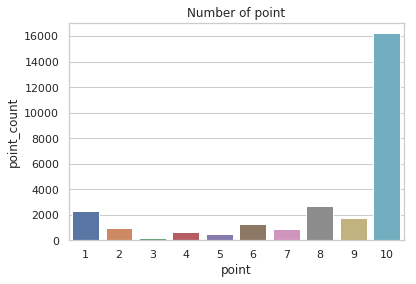

In [18]:
plt.title('Number of point')
sns.barplot(x = df_count['point'], y = df_count['point_count'])

In [19]:
df['point'].describe()

count    27408.000000
mean         8.131604
std          2.961634
min          1.000000
25%          8.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: point, dtype: float64

### 각 user가 point를 준 영화 갯수

In [20]:
users_nb = df['user_id'].value_counts().reset_index()
users_nb.columns = ['user_id', 'nb_lines']
users_nb['nb_lines'].describe()

count    16681.000000
mean         1.643067
std          1.834992
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         59.000000
Name: nb_lines, dtype: float64

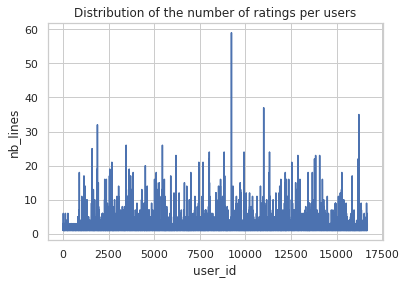

In [21]:
plt.title("Distribution of the number of ratings per users")
plt.ylabel('number of points')
sns.lineplot(x=users_nb['user_id'], y=users_nb['nb_lines'])

In [22]:
df = pd.merge(df, users_nb, on='user_id')
df.tail()

,index,movie,name,point,user_id,movie_id,nb_lines
27403,27399,드래곤 길들이기 3,sukl****,10,13760,517,1
27404,27400,타임 체인저,djfi****,9,3312,1961,1
27405,27401,뺑반,sh04****,10,12826,1019,1
27406,27402,극한직업,jute****,8,7476,246,2
27407,27407,미래의 미라이,jute****,6,7476,797,2


### 영화 별 point 받은 횟수

In [23]:
movies_nb = df['movie_id'].value_counts().reset_index()
movies_nb.columns = ['movie_id', 'nb_movie_lines']
movies_nb['nb_movie_lines'].describe()

count    2274.000000
mean       12.052770
std       149.164032
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max      5716.000000
Name: nb_movie_lines, dtype: float64

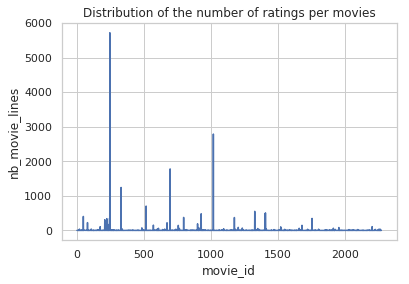

In [24]:
plt.title("Distribution of the number of ratings per movies")
plt.ylabel('number of points')
sns.lineplot(x=movies_nb['movie_id'], y=movies_nb['nb_movie_lines'])

In [25]:
df = pd.merge(df, movies_nb, on='movie_id')
df.tail()

,index,movie,name,point,user_id,movie_id,nb_lines,nb_movie_lines
27403,26579,미친개들,2498****,5,301,826,1,1
27404,26882,베를린,qutt****,10,11823,908,1,1
27405,27194,극장판 포켓 몬스터 DP - 아르세우스 초극의 시공으로,ben2****,9,1724,240,1,1
27406,27299,에너미 라인스,dizi****,1,3298,1426,1,1
27407,27400,타임 체인저,djfi****,9,3312,1961,1,1


### 영화별 포인트 합산 점수

In [26]:
movie_point = df[['movie','point']]
movie_point = movie_point.groupby(['movie']).sum()
movie_point = movie_point.sort_values(by=['point'], ascending=False).reset_index()
movie_point.head(6)

,movie,point
0,극한직업,51324
1,뺑반,20325
2,말모이,15969
3,글래스,13682
4,내안의 그놈,10053
5,드래곤 길들이기 3,6685


### point 받은 횟수가 500개 이상인 영화의 포인트 평균 점수

In [28]:
avg_point = df.groupby(['movie_id']).mean()['point']
avg_point = pd.DataFrame(avg_point)
avg_point['movie_id'] = avg_point.index
avg_point.columns = ['avg_point','movie_id']
df = pd.merge(df, avg_point, on='movie_id')
df.tail()

,index,movie,name,point,user_id,movie_id,nb_lines,nb_movie_lines,avg_point
27403,26579,미친개들,2498****,5,301,826,1,1,5.0
27404,26882,베를린,qutt****,10,11823,908,1,1,10.0
27405,27194,극장판 포켓 몬스터 DP - 아르세우스 초극의 시공으로,ben2****,9,1724,240,1,1,9.0
27406,27299,에너미 라인스,dizi****,1,3298,1426,1,1,1.0
27407,27400,타임 체인저,djfi****,9,3312,1961,1,1,9.0


In [29]:
df[df['nb_movie_lines'] >= 500][['movie','avg_point']].groupby('movie').mean().sort_values(by=['avg_point'],ascending=False)

,avg_point
movie,
드래곤 길들이기 3,9.482270
언더독,9.393701
극한직업,8.979006
말모이,8.976391
아쿠아맨,8.327306
내안의 그놈,8.087691
글래스,8.010539
뺑반,7.292788


# 3. <big>modeling</big>

## 3.1 test / train data split

In [30]:
users = df.user_id.unique()
movies = df.movie_id.unique()
print("users_shape =",users.shape,"movies_shape =",movies.shape)  

users_shape = (16681,) movies_shape = (2274,)


In [33]:
train, test = train_test_split(df, test_size=0.2)

### train data 갯수 : `21926`

In [34]:
print(len(train))
train.tail()

21926


,index,movie,name,point,user_id,movie_id,nb_lines,nb_movie_lines,avg_point
15363,5577,말모이,real****,10,11944,696,16,1779,8.976391
19637,1254,마약왕,slrh****,1,13269,673,2,222,5.261261
20161,1211,미래의 미라이,fncp****,10,4562,797,2,377,5.904509
22744,271,아내가 결혼했다,tjwk****,10,14274,1278,2,1,10.000000
3553,13696,내안의 그놈,gjwg****,10,4944,330,1,1243,8.087691


### test data 갯수 : `5482`

In [36]:
print(len(test))
test.tail()

5482


,index,movie,name,point,user_id,movie_id,nb_lines,nb_movie_lines,avg_point
25262,25352,디스트릭트 9,ll07****,10,9136,530,1,6,9.833333
24725,7884,크레이지 리치 아시안,inha****,1,6434,1922,3,9,5.111111
9725,26540,극한직업,pwh1****,10,11536,246,1,5716,8.979006
3675,18114,내안의 그놈,ljw2****,8,9092,330,1,1243,8.087691
19165,7839,언니,takg****,1,13992,1406,1,482,4.728216


## 3.2 Model_Factorization(Dot)

In [76]:
class ModelFacto:
    
    def __init__(self, embedding_size, optimizer='adam', loss ='mae'):
        self.embedding_size = embedding_size
        self.optimizer = optimizer
        self.loss = loss
    
    def model_layer(self):
        # input_layer
        user_id_input = Input(shape=[1], name='user')
        item_id_input = Input(shape=[1], name='item')
        
        # embedding_layer
        user_embedding = Embedding(output_dim=self.embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
        item_embedding = Embedding(output_dim=self.embedding_size, input_dim=movies.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)
        
        # flatten layer
        user_vecs = Reshape([embedding_size])(user_embedding)
        item_vecs = Reshape([embedding_size])(item_embedding)
        
        # Output layer
        y = Dot(1, normalize=False)([user_vecs, item_vecs])
        
        model = Model(inputs=[user_id_input, item_id_input], outputs=y)
        
        model.compile(loss=self.loss,
                      optimizer=self.optimizer)
        return model
    
        
        
    def summary(self):
        model = self.model_layer()
        model.summary()
        
    def svg(self):
        model = self.model_layer()
        return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
        
    def fit(self):
        model = self.model_layer()
        mainpath = '/Users/james/Documents/pyenv/tensorflow/personal_project'
        save_path = mainpath + "/models"
        mytime = time.strftime("%Y_%m_%d_%H_%M")
        modname = 'matrix_facto_{}_'.format(self.embedding_size) + mytime 
        thename = save_path + '/' + modname + '.h5'
        mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)
        
        history = model.fit([train['user_id'], train['movie_id']]
                           , train['point']
                           , batch_size=50, epochs=10
                           , validation_split=0.1
                           , callbacks=[mcheck]
                           , shuffle=True)
        
        with open(mainpath + '/histories/' + modname + '.pkl', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

In [80]:
def loss_graph(hisotry_ls):
    mainpath = '/Users/james/Documents/pyenv/tensorflow/personal_project'
    for val in hisotry_ls:
        with open(mainpath + '/histories/' + val, 'rb') as file_pi:
            the_pickle = pickle.load(file_pi)
            plt.plot(the_pickle['loss'], label='loss_'+val, linestyle='--')
            plt.plot(the_pickle['val_loss'], label='val_loss'+val)
    plt.legend()
    plt.ylim(0,10)
    
    return pd.DataFrame(the_pickle, columns=['loss', 'val_loss']).head(10).transpose()
    
                

### model_facto_10 
- embedding_size : 10
- train MAE : 3.9
- validation loss : 7.18

### `loss score`

In [78]:
model_facto_10 = ModelFacto(10)
model_facto_10.fit()

Train on 19733 samples, validate on 2193 samples
Epoch 1/10
19733/19733 [==============================] - 3s 138us/step - loss: 8.1357 - val_loss: 8.1400
Epoch 2/10
19733/19733 [==============================] - 2s 112us/step - loss: 8.1181 - val_loss: 8.1276
Epoch 3/10
19733/19733 [==============================] - 2s 110us/step - loss: 7.9967 - val_loss: 8.0793
Epoch 4/10
19733/19733 [==============================] - 2s 111us/step - loss: 7.6960 - val_loss: 7.9905
Epoch 5/10
19733/19733 [==============================] - 2s 116us/step - loss: 7.2475 - val_loss: 7.8739
Epoch 6/10
19733/19733 [==============================] - 2s 116us/step - loss: 6.6878 - val_loss: 7.7396
Epoch 7/10
19733/19733 [==============================] - 2s 116us/step - loss: 6.0387 - val_loss: 7.5942
Epoch 8/10
19733/19733 [==============================] - 2s 114us/step - loss: 5.3173 - val_loss: 7.4406
Epoch 9/10
19733/19733 [==============================] - 2s 108us/step - loss: 4.5759 - val_loss: 7.29

### `model summary`

In [82]:
model_facto_10.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        166810      user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        22740       item[0][0]                       
__________________________________________________________________________________________________
reshape_25

### `Error Graph`

,0,1,2,3,4,5,6,7,8,9
loss,8.135727,8.118095,7.996657,7.695979,7.247486,6.687834,6.038724,5.317258,4.575901,3.900819
val_loss,8.139970,8.127555,8.079277,7.990482,7.873907,7.739571,7.594226,7.440572,7.299391,7.182985


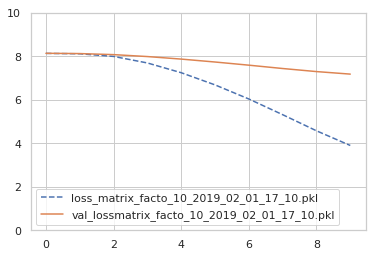

In [81]:
history_ls = ['matrix_facto_10_2019_02_01_17_10.pkl']
loss_graph(history_ls)

## 3.3 Dense_Model(Concat)

In [86]:
class ModelDense:
    
    def __init__(self, embedding_size, optimizer='adam', loss ='mae'):
        self.embedding_size = embedding_size
        self.optimizer = optimizer
        self.loss = loss
    
    def model_layer(self):
        # input_layer
        user_id_input = Input(shape=[1], name='user')
        item_id_input = Input(shape=[1], name='item')
        
        # embedding_layer
        user_embedding = Embedding(output_dim=self.embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
        item_embedding = Embedding(output_dim=self.embedding_size, input_dim=movies.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)
        
        # flatten layer
        user_vecs = Reshape([embedding_size])(user_embedding)
        item_vecs = Reshape([embedding_size])(item_embedding)
        
        # Concate two layer(user_vecs, item_vecs)
        input_vecs = Concatenate()([user_vecs, item_vecs])
        
        # Dense layer
        x = Dense(128, activation='relu')(input_vecs)
        # x = Dense(128, activation='relu')(x)
        
        # Output layer
        y = Dense(1)(x)
        
        model = Model(inputs=[user_id_input, item_id_input], outputs=y)
        
        model.compile(loss=self.loss,
                      optimizer=self.optimizer)
        return model
    
      
    
        
        
    def summary(self):
        model = self.model_layer()
        model.summary()
        
    def svg(self):
        model = self.model_layer()
        return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
        
    def fit(self):
        model = self.model_layer()
        mainpath = '/Users/james/Documents/pyenv/tensorflow/personal_project'
        save_path = mainpath + "/models"
        mytime = time.strftime("%Y_%m_%d_%H_%M")
        modname = 'dense_{}_'.format(self.embedding_size) + mytime 
        thename = save_path + '/' + modname + '.h5'
        mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)
        
        history = model.fit([train['user_id'], train['movie_id']]
                           , train['point']
                           , batch_size=50, epochs=10
                           , validation_split=0.1
                           , callbacks=[mcheck]
                           , shuffle=True)
        
        with open(mainpath + '/histories/' + modname + '.pkl', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

### model_dense_10 
- embedding_size : 10
- dense : 128
- train MAE : 3.9
- validation loss : 7.18

### `loss score`

In [88]:
dense_10_128 = ModelDense(10)
dense_10_128.fit()

Train on 19733 samples, validate on 2193 samples
Epoch 1/10
19733/19733 [==============================] - 3s 155us/step - loss: 3.5043 - val_loss: 1.9468
Epoch 2/10
19733/19733 [==============================] - 2s 113us/step - loss: 1.7692 - val_loss: 1.8368
Epoch 3/10
19733/19733 [==============================] - 2s 113us/step - loss: 1.3801 - val_loss: 1.8554
Epoch 4/10
19733/19733 [==============================] - 2s 112us/step - loss: 1.0524 - val_loss: 1.8969
Epoch 5/10
19733/19733 [==============================] - 2s 116us/step - loss: 0.8820 - val_loss: 1.9060
Epoch 6/10
19733/19733 [==============================] - 2s 116us/step - loss: 0.7867 - val_loss: 1.8922
Epoch 7/10
19733/19733 [==============================] - 2s 116us/step - loss: 0.7340 - val_loss: 1.9286
Epoch 8/10
19733/19733 [==============================] - 2s 112us/step - loss: 0.7035 - val_loss: 1.9047
Epoch 9/10
19733/19733 [==============================] - 2s 110us/step - loss: 0.6801 - val_loss: 1.90

### `model summary`

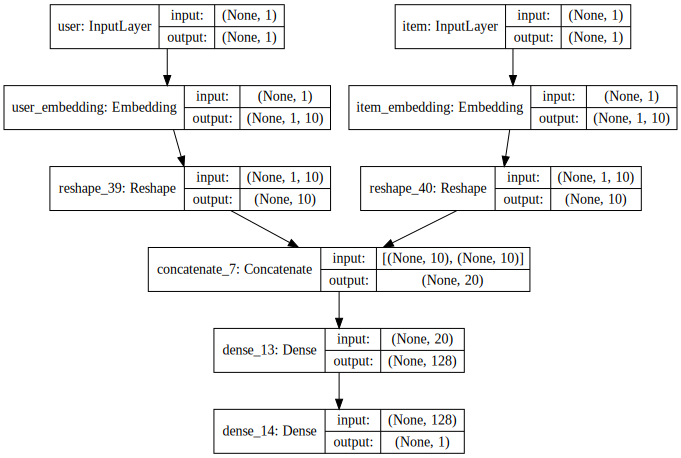

In [89]:
dense_10_128 = ModelDense(10)
dense_10_128.svg()

### `Error Graph`

,0,1,2,3,4,5,6,7,8,9
loss,3.504327,1.769214,1.380132,1.052425,0.882022,0.786668,0.734035,0.703547,0.680059,0.660828
val_loss,1.946802,1.836781,1.855381,1.896879,1.905974,1.892182,1.928598,1.904748,1.908106,1.927934


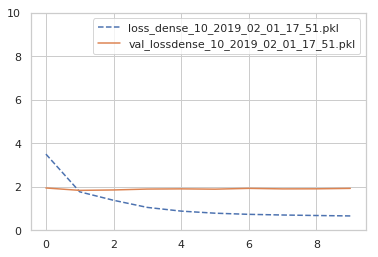

In [90]:
history_ls = ['dense_10_2019_02_01_17_51.pkl']
loss_graph(history_ls)

## 3.4 model_dense_10 과 model_facto_10의 loss 비교

,0,1,2,3,4,5,6,7,8,9
loss,8.135727,8.118095,7.996657,7.695979,7.247486,6.687834,6.038724,5.317258,4.575901,3.900819
val_loss,8.139970,8.127555,8.079277,7.990482,7.873907,7.739571,7.594226,7.440572,7.299391,7.182985


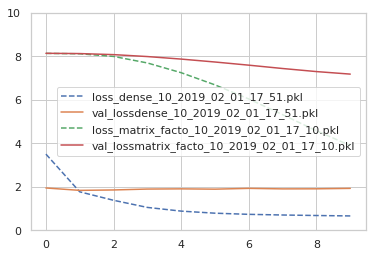

In [91]:
history_ls = ['dense_10_2019_02_01_17_51.pkl','matrix_facto_10_2019_02_01_17_10.pkl']
loss_graph(history_ls)

## 4.1 optimizer = `Adam`
- epoch : 100
- latent_factor : 3
- MAE : 6.20

### `layer`

In [48]:
n_users, n_movies = len(df.user_id.unique()), len(df.movie_id.unique())
n_latent_factors = 3

In [49]:
movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_embedding

<tf.Tensor 'NonNegMovie-Embedding/embedding_lookup/Identity:0' shape=(?, 1, 3) dtype=float32>

In [50]:
user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors, name='NonNegUser-Embedding', embeddings_constraint=non_neg())(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
user_vec

<tf.Tensor 'FlattenUsers/Reshape:0' shape=(?, ?) dtype=float32>

In [51]:
prod = keras.layers.dot([movie_vec, user_vec], axes=1, normalize=False)
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [52]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
NonNegMovie-Embedding (Embeddin (None, 1, 3)         6345        Movie[0][0]                      
__________________________________________________________________________________________________
NonNegUser-Embedding (Embedding (None, 1, 3)         45621       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

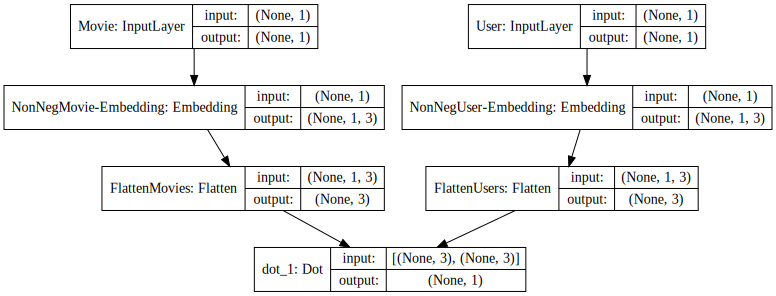

In [62]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [53]:
history = model.fit([train.user_id, train.movie_id], train.point, epochs=100, verbose=0)

Text(0, 0.5, 'Train Error')

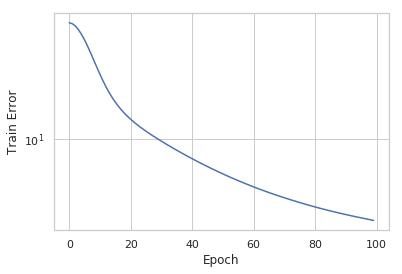

In [54]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

### `MAE(Mean Absolute Error)`

In [55]:
y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_true = test.point

In [56]:
mean_absolute_error(y_true, y_hat)

5.630869742752144

### `Learnt Embedding(Movie, User)`

In [57]:
movie_embedding_learnt = model.get_layer(name='NonNegMovie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,2115.000000,2115.000000,2115.000000
mean,1.883262,1.889277,1.870459
std,1.133208,1.121489,1.139416
min,-0.000000,-0.000000,-0.000000
25%,1.159521,1.216740,0.997336
50%,2.150859,2.150606,2.149696
75%,2.544935,2.549323,2.567499
max,4.589823,4.589783,4.592566


In [58]:
user_embedding_learnt = model.get_layer(name='NonNegUser-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,15207.000000,15207.000000,15207.000000
mean,0.700658,0.701510,0.699485
std,0.422532,0.423422,0.422464
min,-0.000000,-0.000000,-0.000000
25%,0.430707,0.427207,0.415235
50%,0.853094,0.852761,0.851415
75%,0.912425,0.912931,0.922522
max,2.766741,2.816224,2.806391


## 4.2 optimizer = `Adam`
- epoch : 500
- latent_factor : 3
- MAE : 6.20

### `layer`

In [163]:
n_users, n_movies = len(df.user_id.unique()), len(df.movie_id.unique())
n_latent_factors = 3

In [164]:
movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_embedding

<tf.Tensor 'NonNegMovie-Embedding_7/embedding_lookup/Identity:0' shape=(?, 1, 3) dtype=float32>

In [165]:
user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors, name='NonNegUser-Embedding', embeddings_constraint=non_neg())(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
user_vec

<tf.Tensor 'FlattenUsers_8/Reshape:0' shape=(?, ?) dtype=float32>

In [166]:
prod = keras.layers.dot([movie_vec, user_vec], axes=1, normalize=False)
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

### `model summary`

In [167]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
NonNegMovie-Embedding (Embeddin (None, 1, 3)         3399        Movie[0][0]                      
__________________________________________________________________________________________________
NonNegUser-Embedding (Embedding (None, 1, 3)         20619       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

### `Error Graph`

In [168]:
history = model.fit([train.user_id, train.movie_id], train.point, epochs=500, verbose=0)

Text(0, 0.5, 'Train Error')

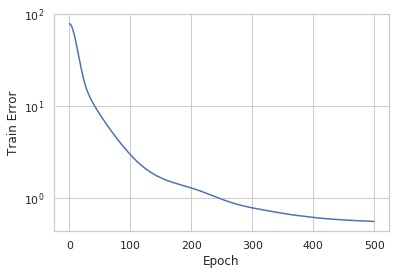

In [169]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

### `MAE(Mean Absolute Error)`

In [170]:
y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_true = test.point

In [171]:
mean_absolute_error(y_true, y_hat)

6.224

### `Learnt Embedding(Movie, User)`

In [172]:
movie_embedding_learnt = model.get_layer(name='NonNegMovie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,1133.000000,1133.000000,1133.000000
mean,1.801747,1.833877,1.798484
std,1.382380,1.391093,1.420996
min,-0.000000,-0.000000,-0.000000
25%,0.454593,0.558505,0.448238
50%,1.838351,1.846816,1.823929
75%,2.761463,2.790259,2.722675
max,7.891548,7.372180,8.117141


In [173]:
user_embedding_learnt = model.get_layer(name='NonNegUser-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,6873.000000,6873.000000,6873.000000
mean,0.873798,0.874937,0.886296
std,0.580303,0.591070,0.594667
min,-0.000000,-0.000000,-0.000000
25%,0.346093,0.355701,0.442927
50%,1.087010,1.074983,1.101935
75%,1.129438,1.120063,1.124678
max,6.197117,6.042282,6.134395


## 4.3 optimizer = `SGD`(Stochastic gradient descent optimizer)
- epoch : 100
- latent_factor : 3
- MAE : 6.1235

### `layer`

In [200]:
n_users, n_movies = len(df.user_id.unique()), len(df.movie_id.unique())
n_latent_factors = 3

In [201]:
movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_embedding

<tf.Tensor 'NonNegMovie-Embedding_8/embedding_lookup/Identity:0' shape=(?, 1, 3) dtype=float32>

In [202]:
user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors, name='NonNegUser-Embedding', embeddings_constraint=non_neg())(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
user_vec

<tf.Tensor 'FlattenUsers_9/Reshape:0' shape=(?, ?) dtype=float32>

In [203]:
prod = keras.layers.dot([movie_vec, user_vec], axes=1, normalize=False)
model = keras.Model([user_input, movie_input], prod)
model.compile('sgd', 'mean_squared_error')

### `model summary`

In [204]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
NonNegMovie-Embedding (Embeddin (None, 1, 3)         3399        Movie[0][0]                      
__________________________________________________________________________________________________
NonNegUser-Embedding (Embedding (None, 1, 3)         20619       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

### `Error Graph`

In [205]:
history = model.fit([train.user_id, train.movie_id], train.point, epochs=100, verbose=0)

Text(0, 0.5, 'Train Error')

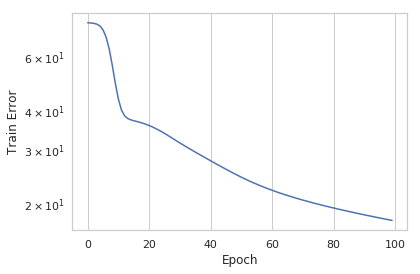

In [206]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

### `MAE(Mean Absolute Error)`

In [207]:
y_hat = np.round(model.predict([test.user_id, test.movie_id]),0)
y_true = test.point

In [208]:
mean_absolute_error(y_true, y_hat)

6.74

### `Learnt Embedding(Movie, User)`

In [139]:
movie_embedding_learnt = model.get_layer(name='NonNegMovie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,1133.000000,1133.000000,1133.000000
mean,0.824630,0.947791,0.992659
std,1.084782,1.080911,1.145034
min,0.000000,0.000000,0.000000
25%,0.043048,0.044711,0.041723
50%,0.444850,0.505641,0.521075
75%,1.233969,1.588560,1.658374
max,15.324163,7.887859,6.678165


In [140]:
user_embedding_learnt = model.get_layer(name='NonNegUser-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,6873.000000,6873.000000,6873.000000
mean,0.469553,0.461546,0.488873
std,0.332779,0.372263,0.389991
min,0.000000,0.000000,0.000000
25%,0.140787,0.139480,0.141392
50%,0.575946,0.444830,0.477104
75%,0.582472,0.645901,0.679435
max,3.421297,2.735481,2.821525
